### 캐글 사이트
https://www.kaggle.com/competitions/playground-series-s3e2/code
참고
https://www.kaggle.com/code/viktortaran/ps-s-3-e-2?scriptVersionId=116455114
https://www.kaggle.com/code/k0takahashi/ps-s3e2-2023-stroke-prediction-8th-place

In [1]:
!python --version

Python 3.11.2


In [27]:
# # Python Theme 변경
# # 참고 : https://realblack0.github.io/2020/05/13/jupyter-notebook-themes.html
# # Theme List
# !jt -l
# # Theme Change
# !jt -h
# !jt -t onedork -fs 115 -nfs 125 -tfs 115 -dfs 115 -ofs 115 -cursc r -cellw 80% -lineh 115  -kl -T -N -altout

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler # down
from imblearn.over_sampling import RandomOverSampler, SMOTE  # up, smote
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import optuna
from optuna import Trial, visualization
from optuna.samplers import TPESampler
import eli5
from eli5.sklearn import PermutationImportance
pd.set_option('display.max_column', None)

In [3]:
original = pd.read_csv('./healthcare-dataset-stroke-data.csv')
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sample = pd.read_csv('./sample_submission.csv')

train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


In [22]:
train.shape, test.shape, original.shape

((15304, 12), (10204, 11), (5110, 12))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB


In [7]:
train.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [9]:
train.duplicated().sum()

0

In [5]:
train.nunique()

id                   15304
gender                   3
age                    106
hypertension             2
heart_disease            2
ever_married             2
work_type                5
Residence_type           2
avg_glucose_level     3740
bmi                    407
smoking_status           4
stroke                   2
dtype: int64

In [15]:
test.nunique()

id                   10204
gender                   3
age                    106
hypertension             2
heart_disease            2
ever_married             2
work_type                5
Residence_type           2
avg_glucose_level     3265
bmi                    400
smoking_status           4
dtype: int64

In [11]:
print(train.gender.unique())
train.gender.value_counts()

['Male' 'Female' 'Other']


Female    9446
Male      5857
Other        1
Name: gender, dtype: int64

In [12]:
test.gender.value_counts()

Female    6338
Male      3865
Other        1
Name: gender, dtype: int64

In [16]:
train.work_type.unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [17]:
train.smoking_status.unique()

array(['never smoked', 'formerly smoked', 'Unknown', 'smokes'],
      dtype=object)

In [20]:
train.stroke.value_counts(normalize = True)

0    0.958704
1    0.041296
Name: stroke, dtype: float64

In [19]:
display(train.describe())
print('---------------------------------------------------------------------------------')
display(test.describe())

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000
mean,7651.500000,41.417708,0.049726,0.023327,89.039853,28.112721,0.041296
std,4418.028595,21.444673,0.217384,0.150946,25.476102,6.722315,0.198981
min,0.000000,0.080000,0.000000,0.000000,55.220000,10.300000,0.000000
25%,3825.750000,26.000000,0.000000,0.000000,74.900000,23.500000,0.000000
50%,7651.500000,43.000000,0.000000,0.000000,85.120000,27.600000,0.000000
75%,11477.250000,57.000000,0.000000,0.000000,96.980000,32.000000,0.000000
max,15303.000000,82.000000,1.000000,1.000000,267.600000,80.100000,1.000000


---------------------------------------------------------------------------------


,id,age,hypertension,heart_disease,avg_glucose_level,bmi
count,10204.000000,10204.000000,10204.000000,10204.000000,10204.000000,10204.000000
mean,20405.500000,41.920713,0.051450,0.021756,89.197766,28.242351
std,2945.785407,21.097956,0.220925,0.145894,25.914364,6.733863
min,15304.000000,0.080000,0.000000,0.000000,55.120000,11.500000
25%,17854.750000,26.000000,0.000000,0.000000,75.060000,23.700000
50%,20405.500000,43.500000,0.000000,0.000000,85.070000,27.700000
75%,22956.250000,57.000000,0.000000,0.000000,96.750000,32.000000
max,25507.000000,82.000000,1.000000,1.000000,267.600000,97.600000


In [48]:
train.work_type.value_counts(), train.work_type.value_counts(normalize = True)

(Private          9752
 children         2038
 Self-employed    1939
 Govt_job         1533
 Never_worked       42
 Name: work_type, dtype: int64,
 Private          0.637219
 children         0.133168
 Self-employed    0.126699
 Govt_job         0.100170
 Never_worked     0.002744
 Name: work_type, dtype: float64)

In [4]:
train.gender.value_counts()

Female    9446
Male      5857
Other        1
Name: gender, dtype: int64

In [43]:
test.gender.value_counts(normalize = False)

Female    6338
Male      3865
Other        1
Name: gender, dtype: int64

# EDA / Feature Engineering

## Feature 
#### Id (고유 번호)
1. 데이터 분석 및 결과 도출에 영향을 미치지 않음  
    - "id" 열 제거  
    
#### Gender  (성별)
1. **`Female`, `Male`, `Other` 세 가지로 구성되어 있음**
    - 샘플 갯수(비율)은 `Female` : 9446 (62%), `Male` : 5857 (38%), `Other` : 1 (0%)
    - `train`, `test` 데이터 셋 모두 `Other` 샘플은 1개씩만 존재.
    
&rarr; **`Other`을 그대로 사용 또는 데이터 빈도(frequency)를 기준으로 `Female`로 변경을 시도해볼 수 있음.**

#### Age (나이)
1. **`0~2세` 생후 24개월 미만의 경우 소숫점을 포함해 나이를 계산.**  
    - 태어나자마자 1살로 계산하는 한국과 다르게 해외의 경우 개월수로 나이 계산된다.
    
&rarr; **소숫점을 제거하여 "age" 데이터 단위를 통일해볼 수 있다.**

#### Hypertension (고혈압)
1. **`0` 과 `1`로 이루어진 binary type 데이터**
    - 샘플 갯수(비율)은 `0` : 14543 (95%), `1` : 761 (5%)

#### Heart Disease (심장질환)
1. **`0` 과 `1`로 이루어진 binary type 데이터**
    - 샘플 갯수(비율)은 `0` : 14947 (98%), `1` : 357 (2%)
    
#### Ever Married (결혼 이력)
1. **`No` 와 `Yes`로 이루어진 binary type 데이터**
    - 샘플 갯수(비율)은 `No` : 4919 (32%), `Yes` : 10385 (68%)
    
#### Work Type (직업 유형)
1. **`Private` 과 `Children`, `Self Employed`, `Govt Job`, `Never Worked` 5개의 카테고리로 이루어져있음**
    - `Private : 사기업`, `Children : 미성년자`, `Self Employed : 자영업자`,   </br> 
    `Govt Job : 공무원`, `Never Worked : 취업 경험 없음`
    - 샘플 갯수(비율)은 `Private` : 9752 (64%), `Children` : 2038 (13%), `Self Employed` : 1939 (13%),  
    `Govt Job` : 1533 (10%), `Never Worked` : 42 (0%)

#### Residence Type (주거 유형)
1. **`Rural` 와 `Urban`로 이루어진 binary type 데이터**
    - `Rural : 지방`, `Urban : 도시` </br> 
    - 샘플 갯수(비율)은 `Rural` : 7664 (50%), `Urban` : 7640 (50%)
    
#### Avg Glucose Level (평균 혈당 수치)
1. **float type 데이터**
    - `min` : 55.22, `max` : 267.6, `mean` : 89.04, `std` : 25.48  </br> 

&rarr; **`100 미만` : Normal, `125 이하` : Prediabetes, `126 이상` : Diabetes 분류 가능**

#### BMI (체질량 지수)
1. **float type 데이터**
    - `min` : 10.3, `max` : 80.1, `mean` : 28.11, `std` : 6.72  </br> 
    
&rarr; **`23 미만` : Normal, `25 이하` : Overweight, `30 미만` : Obesity, `30 이상` : Severe Obesity**

#### Smoking Status (흡연 여부)
1. **`never smoked`, `formerly smoked`, `Unknown`, `smokes`로 이루어진 categorical 데이터**
    - `never smoked : 비흡연`, `formerly smoked : 금연`, `Unknown : 미상`, `smokes : 흡연`</br> 
    - 샘플 갯수(비율)은 `never smoked` : 6281 (41%), `formerly smoked` : 2337 (15%), `Unknown` : 4543 (30%), `smokes` : 2143 (14%)

## Target
#### Stroke (뇌졸중)
1. **`0` 와 `1`로 이루어진 binary type 데이터**
    - 샘플 갯수(비율)은 `0` : 14672 (96%), `1` : 632 (4%)
    
## 정리 및 프로세스 &darr; 

**1. `중복 및 결측 값은 없으므로 기본 데이터 처리 불필요`**  
**2. `파라미터 수정 없이 기본 전처리만으로 베이스 모델 구축 및 실행`**  
**3. `캐글 제출을 통해 테스트 결과 (일반화 성능) 확인`**   
**&rarr; 일반적인 질병 예측 task에서의 critical issue는 질병이 없다고 예측했는데, 실제로 질병이 있는 경우(FN)이므로 Recall 성능을 끌어올려야한다.   
하지만 캐글에서 선택한 지표는 AUC이므로 해당 지표를 기준으로 성능 판단**    
**4. `성능 향상 테스트 수행`**  
    **- Scaling Technique**  #데이터 분포 확인후 적절한 테크닉 선택  
        1) `Standard`, 2) `MinMax`, 3) `Robust` 
    **- Parameter Search**  
        1) `optuna`
**5. `Target Imbalance를 해결하기 위한 방법`**  
**&rarr; `주요 과제는 심각한 Target Imbalance, 어떻게 처리할 것인가?`**  
    **- Sampling Technique**  
        1) `Upsampling`, 2) `Downsampling` 3) `SMOTE`  
    **- Class Weight**  
        1) `class_weight`, 2) `scale_pos_weight`

## 결론 &darr; 

**1. Baseline과 비교해서 모델 검증 성능 향상 `(0.52 &rarr 0.83)`**    
**2. test 데이터 성능은 0.893 수준으로 상위권 유저와 큰 차이 없음**  
**3. 건강 문진표 수준의 데이터로도 양호한 성능의 모델 개발 가능**  
**4. 추가 성능 향상을 위해, 새로운 데이터 수집, 새로운 feature engineering 기법 적용, 다양한 모델 테스트를 수행할 수 있음**

# Data Visualization

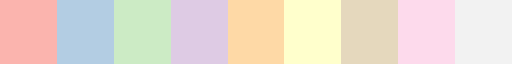

In [32]:
plt.cm.Pastel1

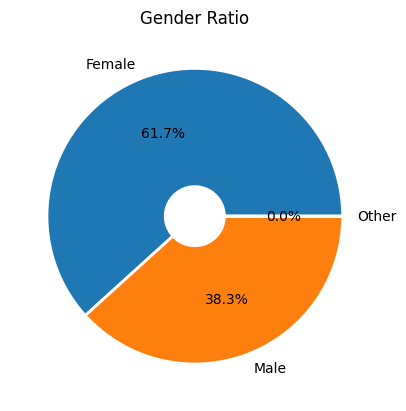

In [11]:
#Gender Ratio
wedgeprops={'width': 0.8, 'edgecolor': 'w', 'linewidth': 2}
plt.pie(train['gender'].value_counts(), labels = ['Female','Male','Other'], autopct='%.1f%%', wedgeprops=wedgeprops)
plt.title('Gender Ratio')
plt.show()

In [65]:
train['gender'].unique()

array(['Male', 'Female', 'Other'], dtype=object)

Gender : Male, Count : 5857


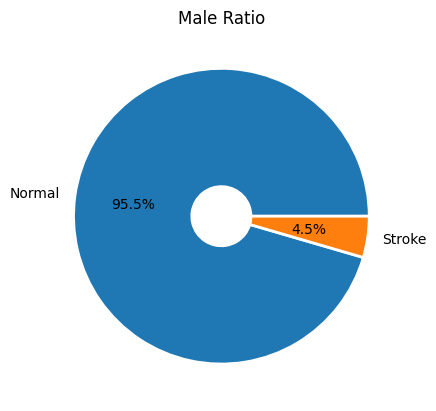

Gender : Female, Count : 9446


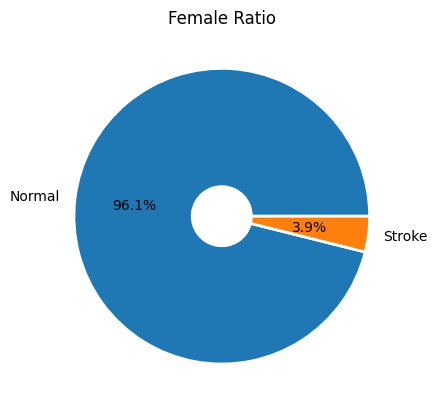

Gender : Other, Count : 1


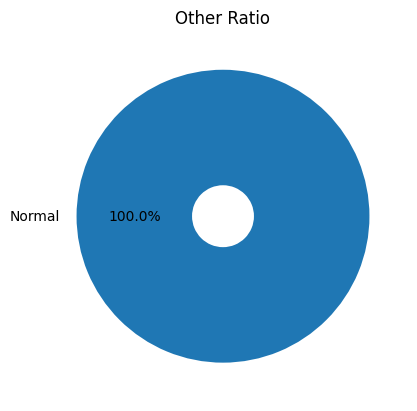

In [135]:
for gen in train['gender'].unique():
    temp = train[train['gender'] == gen]['stroke']
    print(f'Gender : {gen}, Count : {len(temp)}')
    if len(temp.value_counts().index) == 2:
        plt.pie(temp.value_counts(), labels = ['Normal','Stroke'], autopct='%.1f%%', wedgeprops=wedgeprops)
    else :
        plt.pie(temp.value_counts(), labels = ['Normal'], autopct='%.1f%%', wedgeprops=wedgeprops)
    plt.title(gen+' Ratio')
    plt.show()
# train[['gender','stroke']].corr()

<BarContainer object of 83 artists>

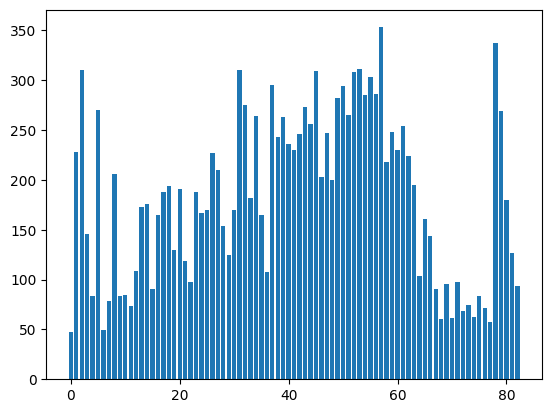

In [39]:
#Age Distribution
plt.bar(train.age.round().value_counts().index,train.age.round().value_counts().values)

In [74]:
def generation(x):
    if x <20 : return 'child'
    elif x<40 : return 'Young Adults'
    elif x<60 : return 'Middle Age'
    else : return 'Senior'
temp = train.copy()
temp['age_cat']=temp['age'].apply(generation)

<BarContainer object of 4 artists>

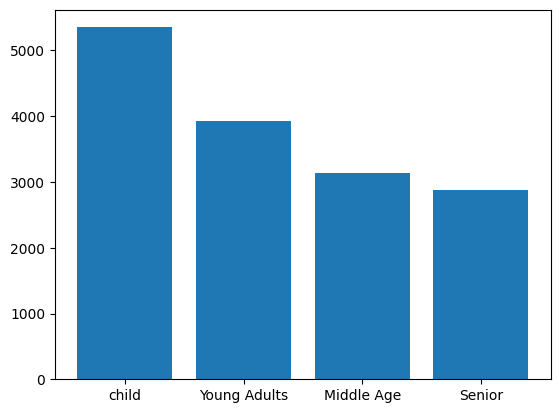

In [97]:
plt.bar(['child','Young Adults', 'Middle Age', 'Senior'],temp['age_cat'].value_counts().values)

Generation : child, Count : 15304


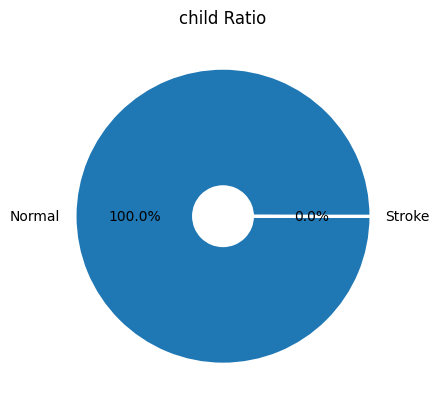

Generation : Young Adults, Count : 15304


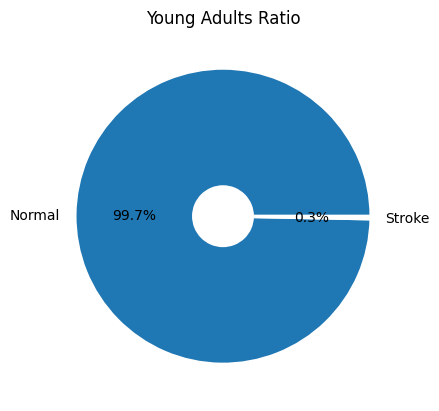

Generation : Middle Age, Count : 15304


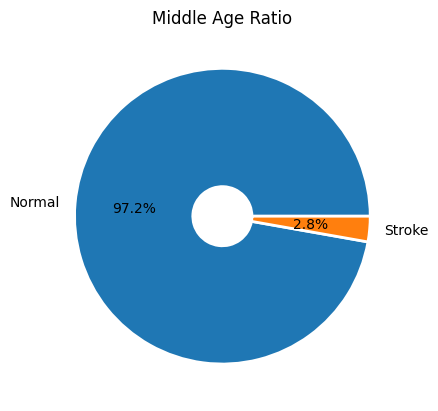

Generation : Senior, Count : 15304


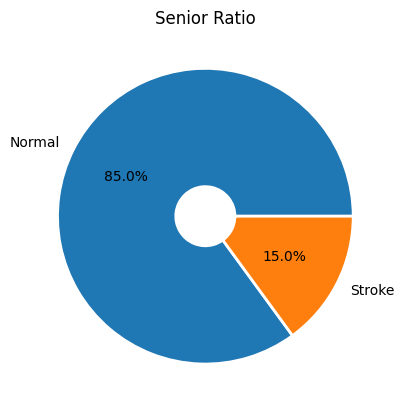

In [114]:
stroke_ratio = []
gen_list = ['child','Young Adults', 'Middle Age', 'Senior']
for cat in gen_list:
    temp1 = temp[temp['age_cat'] == cat]['stroke']
    print(f'Generation : {cat}, Count : {len(temp)}')
    plt.pie(temp1.value_counts(), labels = ['Normal','Stroke'], autopct='%.1f%%', wedgeprops=wedgeprops)
    plt.title(cat+' Ratio')
    plt.show()
    stroke_ratio.append(temp1.value_counts(normalize=True)[1] * 100)

Text(0, 0.5, 'Ratio (%)')

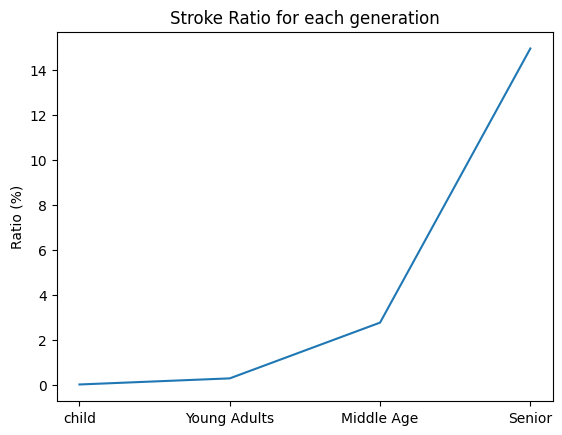

In [116]:
sns.lineplot(y = stroke_ratio, x= gen_list)
plt.title('Stroke Ratio for each generation')
plt.ylabel('Ratio (%)')

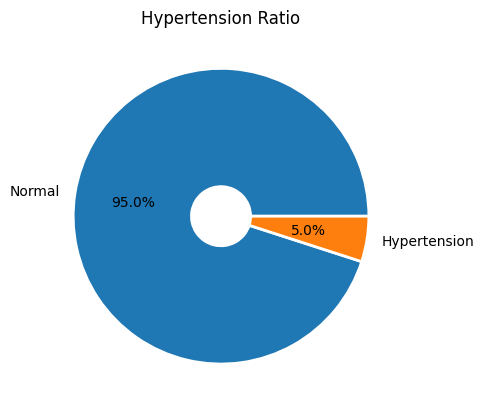

Hypertension : 0, Count : 14543


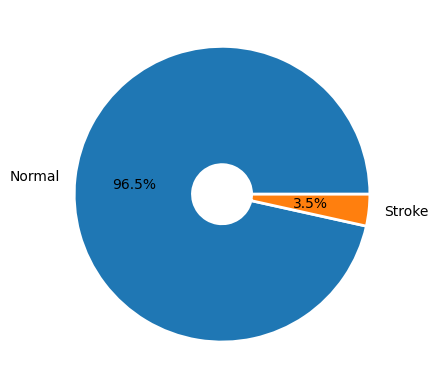

Hypertension : 1, Count : 761


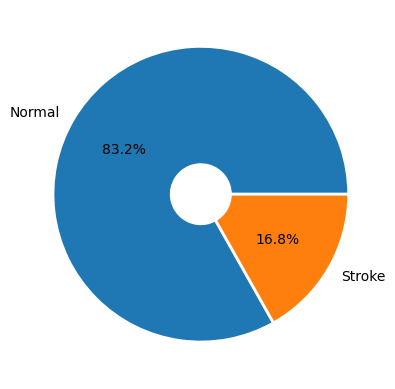

In [125]:
#Hypertension Ratio
wedgeprops={'width': 0.8, 'edgecolor': 'w', 'linewidth': 2}
plt.pie(train['hypertension'].value_counts(), labels = ['Normal','Hypertension'], autopct='%.1f%%', wedgeprops=wedgeprops)
plt.title('Hypertension Ratio')
plt.show()
for cat in train['hypertension'].unique():
    temp = train[train['hypertension'] == cat]['stroke']
    print(f'Hypertension : {cat}, Count : {len(temp)}')
    plt.pie(temp.value_counts(), labels = ['Normal','Stroke'], autopct='%.1f%%', wedgeprops=wedgeprops)
#     plt.title(cat,' Ratio')
    plt.show()

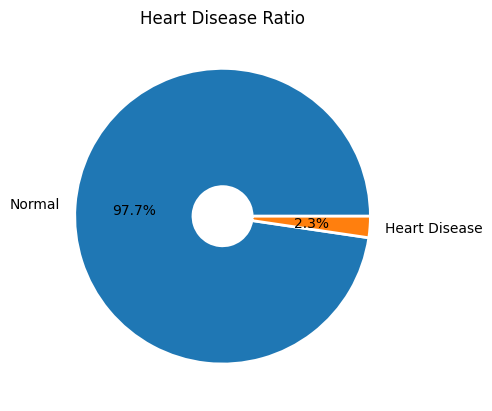

Heart Disease : 0, Count : 14947


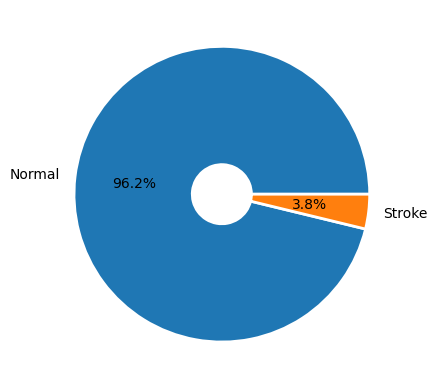

Heart Disease : 1, Count : 357


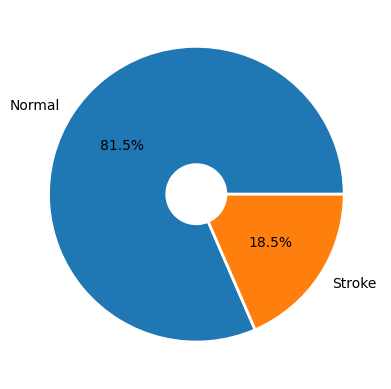

In [126]:
#Heart Disease Ratio
wedgeprops={'width': 0.8, 'edgecolor': 'w', 'linewidth': 2}
plt.pie(train['heart_disease'].value_counts(), labels = ['Normal','Heart Disease'], autopct='%.1f%%', wedgeprops=wedgeprops)
plt.title('Heart Disease Ratio')
plt.show()
for cat in train['heart_disease'].unique():
    temp = train[train['heart_disease'] == cat]['stroke']
    print(f'Heart Disease : {cat}, Count : {len(temp)}')
    plt.pie(temp.value_counts(), labels = ['Normal','Stroke'], autopct='%.1f%%', wedgeprops=wedgeprops)
#     plt.title(cat,' Ratio')
    plt.show()

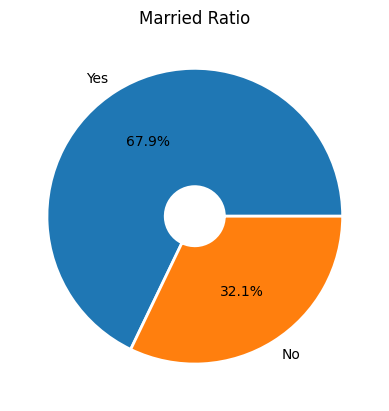

Married : Yes, Count : 10385


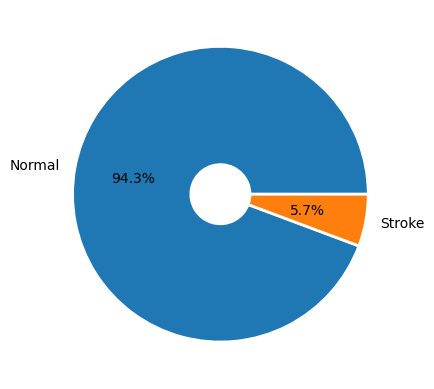

Married : No, Count : 4919


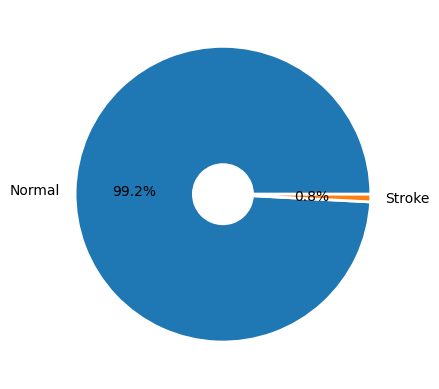

In [127]:
#Ever Married Ratio
wedgeprops={'width': 0.8, 'edgecolor': 'w', 'linewidth': 2}
plt.pie(train['ever_married'].value_counts(), labels = ['Yes','No'], autopct='%.1f%%', wedgeprops=wedgeprops)
plt.title('Married Ratio')
plt.show()
for cat in train['ever_married'].unique():
    temp = train[train['ever_married'] == cat]['stroke']
    print(f'Married : {cat}, Count : {len(temp)}')
    plt.pie(temp.value_counts(), labels = ['Normal','Stroke'], autopct='%.1f%%', wedgeprops=wedgeprops)
#     plt.title(cat,' Ratio')
    plt.show()

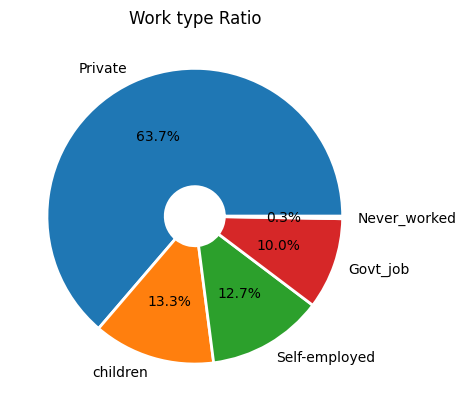

Work type : Private, Count : 9752
Int64Index([0, 1], dtype='int64')


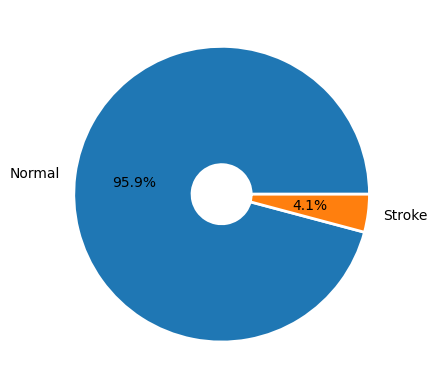

Work type : Self-employed, Count : 1939
Int64Index([0, 1], dtype='int64')


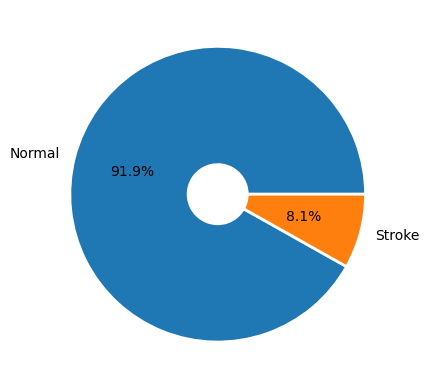

Work type : Govt_job, Count : 1533
Int64Index([0, 1], dtype='int64')


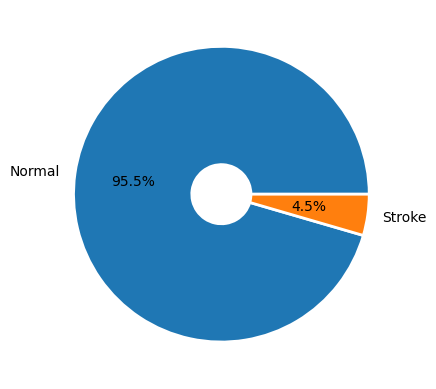

Work type : children, Count : 2038
Int64Index([0, 1], dtype='int64')


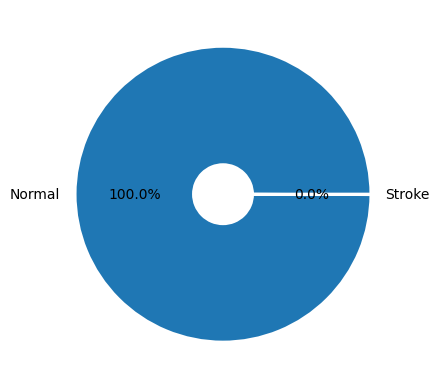

Work type : Never_worked, Count : 42
Int64Index([0], dtype='int64')


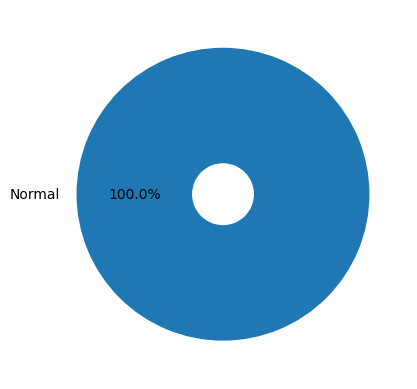

In [134]:
#Work type Ratio
wedgeprops={'width': 0.8, 'edgecolor': 'w', 'linewidth': 2}
plt.pie(train['work_type'].value_counts(), labels = train['work_type'].value_counts().index, autopct='%.1f%%', wedgeprops=wedgeprops)
plt.title('Work type Ratio')
plt.show()
for cat in train['work_type'].unique():
    temp = train[train['work_type'] == cat]['stroke']
    print(f'Work type : {cat}, Count : {len(temp)}')
    print(temp.value_counts().index)
    if len(temp.value_counts().index) ==2:
        plt.pie(temp.value_counts(), labels = ['Normal','Stroke'], autopct='%.1f%%', wedgeprops=wedgeprops)
    else :
        plt.pie(temp.value_counts(), labels = ['Normal'], autopct='%.1f%%', wedgeprops=wedgeprops)
#     plt.title(cat,' Ratio')
    plt.show()

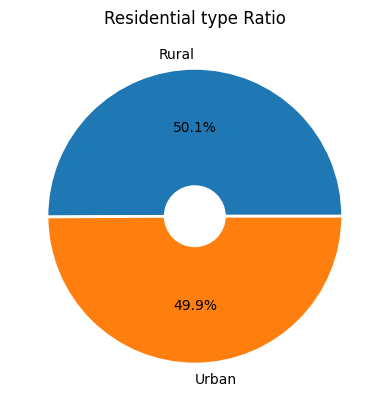

Residential type : Urban, Count : 7640
Int64Index([0, 1], dtype='int64')


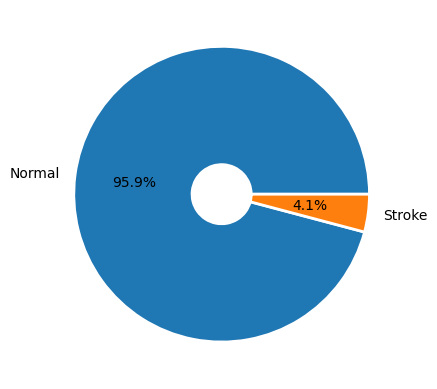

Residential type : Rural, Count : 7664
Int64Index([0, 1], dtype='int64')


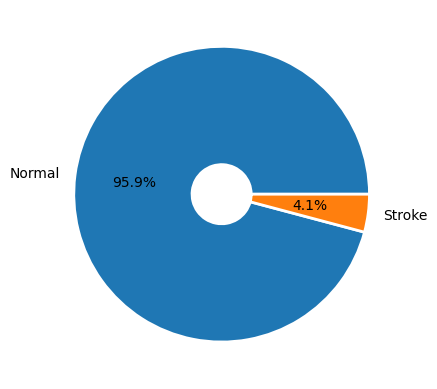

In [136]:
#Residential type Ratio
wedgeprops={'width': 0.8, 'edgecolor': 'w', 'linewidth': 2}
plt.pie(train['Residence_type'].value_counts(), labels = train['Residence_type'].value_counts().index, autopct='%.1f%%', wedgeprops=wedgeprops)
plt.title('Residential type Ratio')
plt.show()
for cat in train['Residence_type'].unique():
    temp = train[train['Residence_type'] == cat]['stroke']
    print(f'Residential type : {cat}, Count : {len(temp)}')
    print(temp.value_counts().index)
    if len(temp.value_counts().index) ==2:
        plt.pie(temp.value_counts(), labels = ['Normal','Stroke'], autopct='%.1f%%', wedgeprops=wedgeprops)
    else :
        plt.pie(temp.value_counts(), labels = ['Normal'], autopct='%.1f%%', wedgeprops=wedgeprops)
#     plt.title(cat,' Ratio')
    plt.show()

<BarContainer object of 3740 artists>

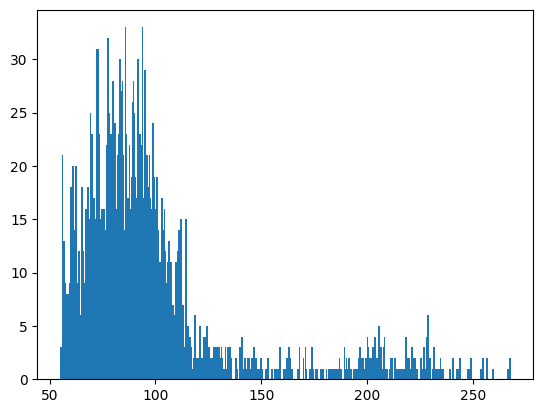

In [137]:
#Glucose Distribution
plt.bar(train['avg_glucose_level'].value_counts().index,train['avg_glucose_level'].value_counts().values)

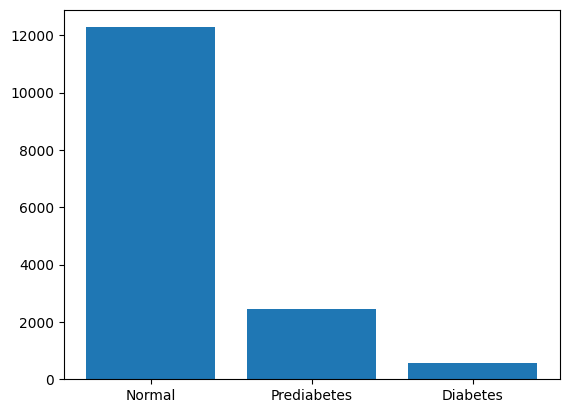

Glucose : Normal, Count : 15304


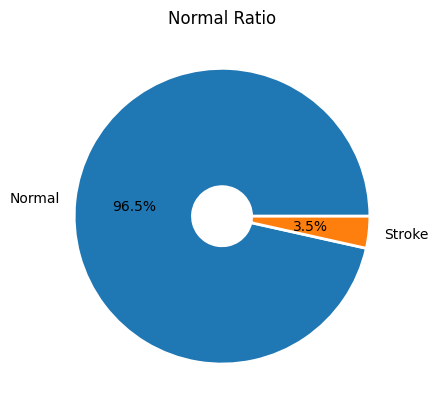

Glucose : Prediabetes, Count : 15304


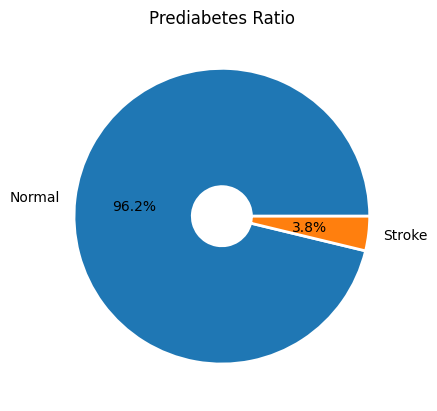

Glucose : Diabetes, Count : 15304


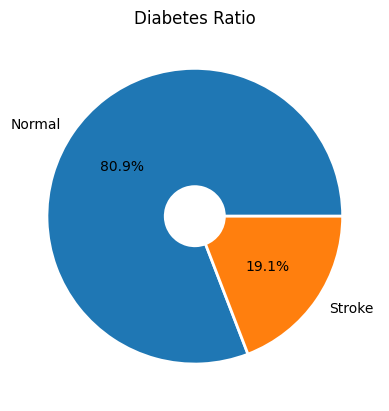

In [142]:
#avg_glucose_level
'''100 미만 : Normal, 125 이하 : Prediabetes, 126 이상 : Diabetes '''

def glucose(x):
    if x <100 : return 'Normal'
    elif x<126 : return 'Prediabetes'
    else : return 'Diabetes'
temp = train.copy()
temp['glucose_cat']=temp['avg_glucose_level'].apply(glucose)
glucose_list = ['Normal','Prediabetes', 'Diabetes']
plt.bar(glucose_list,temp['glucose_cat'].value_counts().values)
plt.show()
stroke_ratio = []
for cat in glucose_list:
    temp1 = temp[temp['glucose_cat'] == cat]['stroke']
    print(f'Glucose : {cat}, Count : {len(temp)}')
    plt.pie(temp1.value_counts(), labels = ['Normal','Stroke'], autopct='%.1f%%', wedgeprops=wedgeprops)
    plt.title(cat+' Ratio')
    plt.show()
    stroke_ratio.append(temp1.value_counts(normalize=True)[1] * 100)

Text(0, 0.5, 'Ratio (%)')

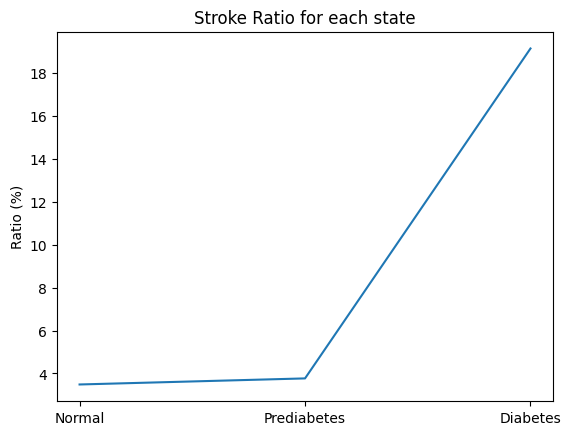

In [143]:
sns.lineplot(y = stroke_ratio, x= glucose_list)
plt.title('Stroke Ratio for each state')
plt.ylabel('Ratio (%)')

<BarContainer object of 407 artists>

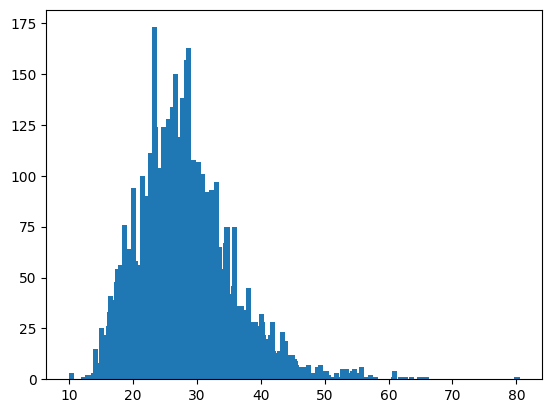

In [228]:
#Glucose Distribution
plt.bar(train['bmi'].value_counts().index,train['bmi'].value_counts().values)

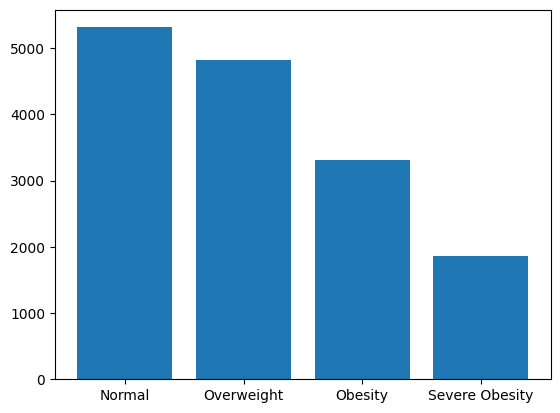

BMI : Normal, Count : 15304


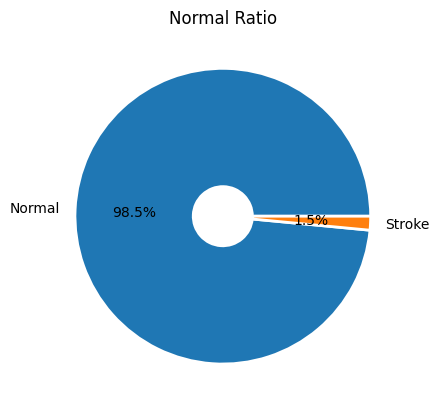

BMI : Overweight, Count : 15304


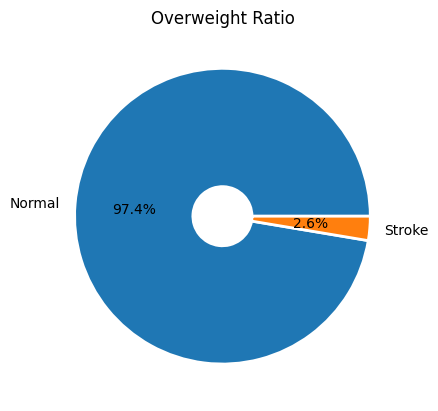

BMI : Obesity, Count : 15304


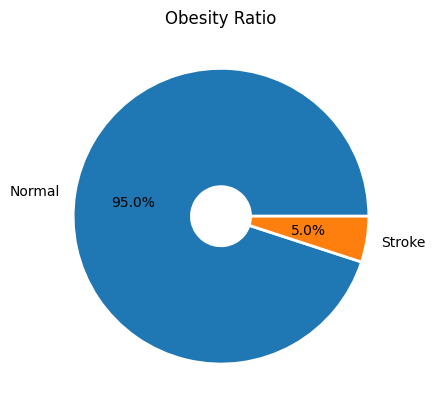

BMI : Severe Obesity, Count : 15304


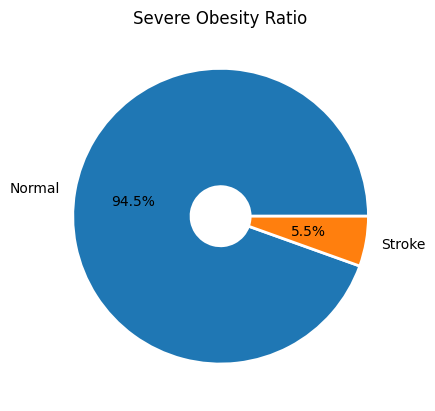

In [144]:
#BMI
'''23 미만 : Normal, 25 이하 : Overweight, 30 미만 : Obesity, 30 이상 : Severe Obesity'''

def BMI(x):
    if x <23 : return 'Normal'
    elif x<=25 : return 'Overweight'
    elif x<30 : return 'Obesity'
    else : return 'Severe Obesity'
temp = train.copy()
temp['bmi_cat']=temp['bmi'].apply(BMI)
BMI_list = ['Normal','Overweight','Obesity', 'Severe Obesity']
plt.bar(BMI_list,temp['bmi_cat'].value_counts().values)
plt.show()
stroke_ratio = []
for cat in BMI_list:
    temp1 = temp[temp['bmi_cat'] == cat]['stroke']
    print(f'BMI : {cat}, Count : {len(temp)}')
    plt.pie(temp1.value_counts(), labels = ['Normal','Stroke'], autopct='%.1f%%', wedgeprops=wedgeprops)
    plt.title(cat+' Ratio')
    plt.show()
    stroke_ratio.append(temp1.value_counts(normalize=True)[1] * 100)

Text(0, 0.5, 'Ratio (%)')

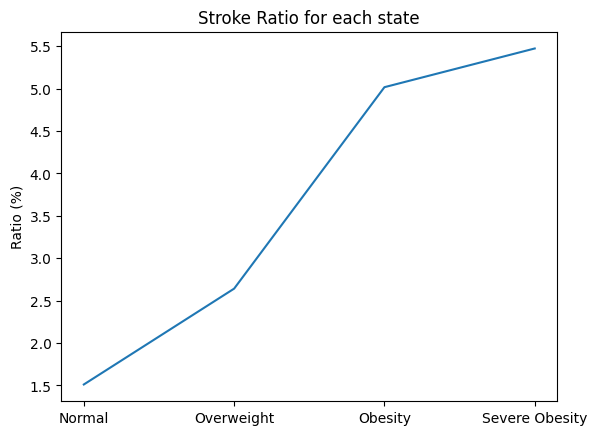

In [145]:
sns.lineplot(y = stroke_ratio, x= BMI_list)
plt.title('Stroke Ratio for each state')
plt.ylabel('Ratio (%)')

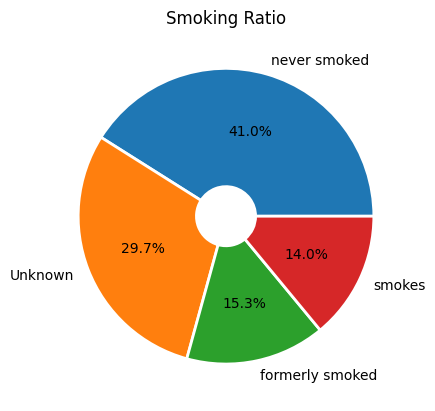

Smoking : never smoked, Count : 6281
Int64Index([0, 1], dtype='int64')


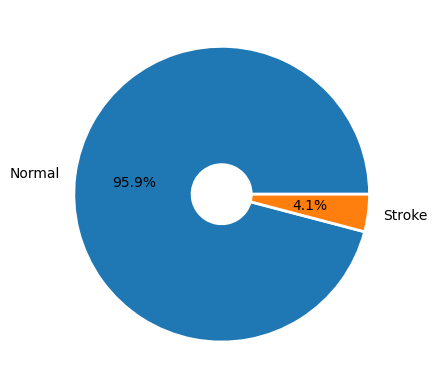

Smoking : formerly smoked, Count : 2337
Int64Index([0, 1], dtype='int64')


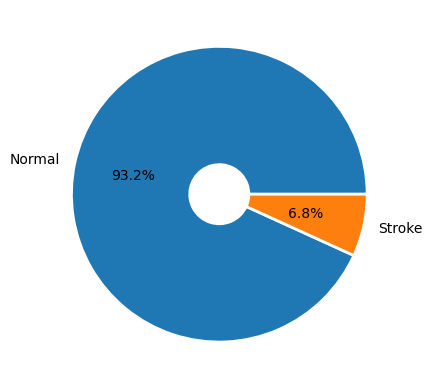

Smoking : Unknown, Count : 4543
Int64Index([0, 1], dtype='int64')


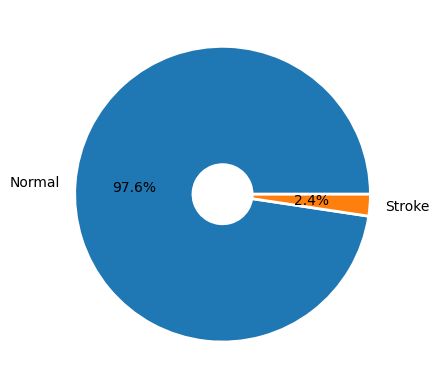

Smoking : smokes, Count : 2143
Int64Index([0, 1], dtype='int64')


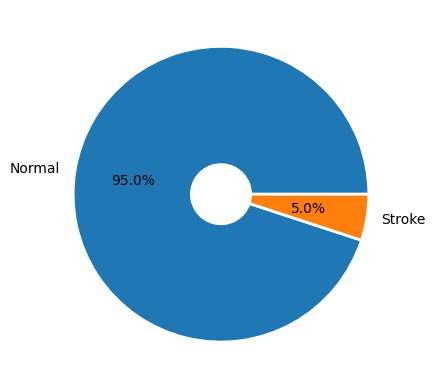

In [146]:
#Smoking Ratio
wedgeprops={'width': 0.8, 'edgecolor': 'w', 'linewidth': 2}
plt.pie(train['smoking_status'].value_counts(), labels = train['smoking_status'].value_counts().index, autopct='%.1f%%', wedgeprops=wedgeprops)
plt.title('Smoking Ratio')
plt.show()
for cat in train['smoking_status'].unique():
    temp = train[train['smoking_status'] == cat]['stroke']
    print(f'Smoking : {cat}, Count : {len(temp)}')
    print(temp.value_counts().index)
    if len(temp.value_counts().index) ==2:
        plt.pie(temp.value_counts(), labels = ['Normal','Stroke'], autopct='%.1f%%', wedgeprops=wedgeprops)
    else :
        plt.pie(temp.value_counts(), labels = ['Normal'], autopct='%.1f%%', wedgeprops=wedgeprops)
#     plt.title(cat,' Ratio')
    plt.show()

In [6]:
temp = train.copy()
temp['smoke'] = train['smoking_status'].replace({"never smoked":'No',"Unknown":'No',"formerly smoked":"Yes","smokes":"Yes"})

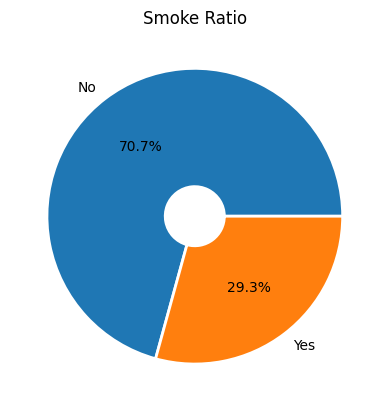

Smoke : No, Count : 10824
Int64Index([0, 1], dtype='int64')


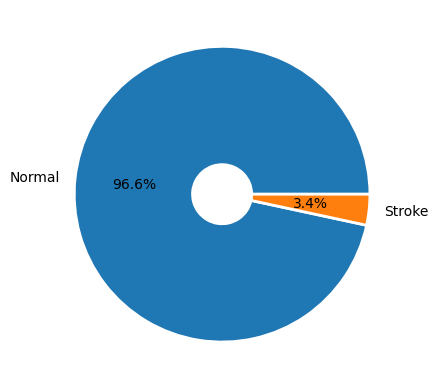

Smoke : Yes, Count : 4480
Int64Index([0, 1], dtype='int64')


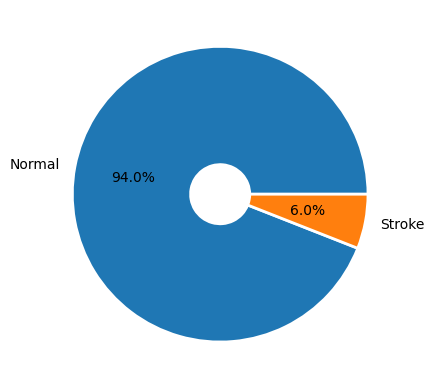

In [9]:
wedgeprops={'width': 0.8, 'edgecolor': 'w', 'linewidth': 2}
plt.pie(temp['smoke'].value_counts(), labels = temp['smoke'].value_counts().index, autopct='%.1f%%', wedgeprops=wedgeprops)
plt.title('Smoke Ratio')
plt.show()
for cat in temp['smoke'].unique():
    tt = temp[temp['smoke']==cat]['stroke']
    print(f'Smoke : {cat}, Count : {len(tt)}')
    print(tt.value_counts().index)
    plt.pie(tt.value_counts(), labels = ['Normal','Stroke'], autopct='%.1f%%', wedgeprops=wedgeprops)
    plt.show()

In [ ]:
#Smoking Ratio
wedgeprops={'width': 0.8, 'edgecolor': 'w', 'linewidth': 2}
plt.pie(train['smoking_status'].value_counts(), labels = train['smoking_status'].value_counts().index, autopct='%.1f%%', wedgeprops=wedgeprops)
plt.title('Smoking Ratio')
plt.show()
for cat in train['smoking_status'].unique():
    temp = train[train['smoking_status'] == cat]['stroke']
    print(f'Smoking : {cat}, Count : {len(temp)}')
    print(temp.value_counts().index)
    if len(temp.value_counts().index) ==2:
        plt.pie(temp.value_counts(), labels = ['Normal','Stroke'], autopct='%.1f%%', wedgeprops=wedgeprops)
    else :
        plt.pie(temp.value_counts(), labels = ['Normal'], autopct='%.1f%%', wedgeprops=wedgeprops)
#     plt.title(cat,' Ratio')
    plt.show()

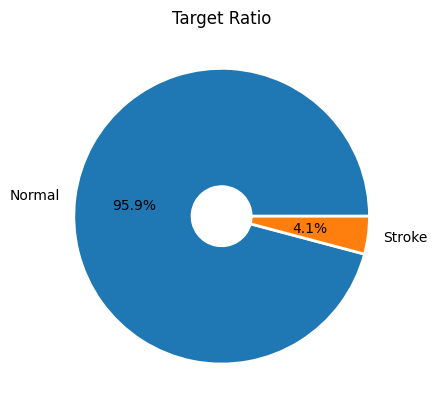

In [82]:
# target = 'stroke'
# colors = plt.cm.Pastel1(range(len(train[target].value_counts().index)))
# colors = plt.cm.Pastel1(range(1,3))
wedgeprops={'width': 0.8, 'edgecolor': 'w', 'linewidth': 2}
plt.pie(train[target].value_counts(), labels = ['Normal','Stroke'], autopct='%.1f%%',wedgeprops=wedgeprops)
plt.title('Target Ratio')
plt.show()

# Baseline

In [148]:
train.drop('id', axis = 1, inplace = True)
target = 'stroke'
X_train = train.drop(target, axis = 1)
y_train = train[target]
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 2, stratify = y_train)

encoder = OrdinalEncoder()
X_train_EN = encoder.fit_transform(X_train)
X_val_EN = encoder.transform(X_val)

model_dt = DecisionTreeClassifier(random_state=2)
model_rf = RandomForestClassifier(random_state=2, n_jobs=-1)
model_xgb = XGBClassifier(random_state = 2, n_jobs=-1)

#######
# DT
######
model_dt.fit(X_train_EN, y_train)
DT_tr = model_dt.predict(X_train_EN)
DT_val = model_dt.predict(X_val_EN)
print('DT results')
# print(f'AUC_train : {roc_auc_score(y_train, DT_tr)}')
# print(classification_report(y_train, DT_tr))
print(f'AUC_val : {roc_auc_score(y_val, DT_val)}')
print(classification_report(y_val, DT_val))
print('-----------------------------------')

#######
# RF
######

model_rf.fit(X_train_EN, y_train)
RF_tr = model_rf.predict(X_train_EN)
RF_val = model_rf.predict(X_val_EN)
print('RF results')
# print(f'AUC_train : {roc_auc_score(y_train, RF_tr)}')
# print(classification_report(y_train, RF_tr))
print(f'AUC_val : {roc_auc_score(y_val, RF_val)}')
print(classification_report(y_val, RF_val))
print('-----------------------------------')

#######
# XGB
######

model_xgb.fit(X_train_EN, y_train)
XGB_tr = model_xgb.predict(X_train_EN)
XGB_val = model_xgb.predict(X_val_EN)
print('XGB results')
# print(f'AUC_train : {roc_auc_score(y_train, XGB_tr)}')
# print(classification_report(y_train, XGB_tr))
print(f'AUC_val : {roc_auc_score(y_val, XGB_val)}')
print(classification_report(y_val, XGB_val))
print('-----------------------------------')



DT results
AUC_val : 0.5984343311430195
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2935
           1       0.20      0.24      0.22       126

    accuracy                           0.93      3061
   macro avg       0.58      0.60      0.59      3061
weighted avg       0.94      0.93      0.93      3061

-----------------------------------
RF results
AUC_val : 0.5262445580162787
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2935
           1       0.44      0.06      0.10       126

    accuracy                           0.96      3061
   macro avg       0.70      0.53      0.54      3061
weighted avg       0.94      0.96      0.94      3061

-----------------------------------
XGB results
AUC_val : 0.5438711770909386
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2935
           1       0.35      0.10      0.15 

In [149]:
baseline = pd.DataFrame([roc_auc_score(y_val, DT_val), roc_auc_score(y_val, RF_val), roc_auc_score(y_val, XGB_val)], columns = ['AUC'],index = ['DT','RF','XGB'])
baseline

,AUC
DT,0.598434
RF,0.526245
XGB,0.543871


# Sampling & Class weight

In [ ]:
original = pd.read_csv('./healthcare-dataset-stroke-data.csv')
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sample = pd.read_csv('./sample_submission.csv')

train.head()

In [7]:
def generation(x):
    if x <20 : return 'child'
    elif x<40 : return 'Young Adults'
    elif x<60 : return 'Middle Age'
    else : return 'Senior'
def glucose(x):
    if x <100 : return 'Normal'
    elif x<126 : return 'Prediabetes'
    else : return 'Diabetes'
def BMI(x):
    if x <23 : return 'Normal'
    elif x<=25 : return 'Overweight'
    elif x<30 : return 'Obesity'
    else : return 'Severe Obesity'
    
def feature_engineering(df):
    df['gender'] = df['gender'].replace({'Female':0,'Male':1,'Other':0})
    df['age'] = df['age'].round()
    df['generation'] = df['age'].apply(generation)
    df['diabetes'] = df['avg_glucose_level'].apply(glucose)
    df['obesity'] = df['bmi'].apply(BMI)
    df['work_state'] = df['work_type'].replace({'Private':1,'Self-employed':1,'Govt_job':1,'children':0,'Never_worked':0})
    df['risk factor'] = df['heart_disease'] + df['hypertension'] + (df['generation']=='Middle Age') + (df['generation']=='Senior') + (df['diabetes']=='Diabetes') + (df['obesity']=='Obesity') + (df['obesity']=='Severe Obesity')
    return df


In [8]:
X_train = feature_engineering(train)
X_test = feature_engineering(test)

target = 'stroke'
y_train = X_train[target]
X_train = X_train.drop(target, axis=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 2, stratify = y_train)

encoder = OrdinalEncoder()
X_train_EN = encoder.fit_transform(X_train)
X_val_EN = encoder.transform(X_val)

In [29]:
def modeling(X,y):
    best_model = []
    best_report = []
    model_list = ['DT','RF','XGB']
    model_dt = DecisionTreeClassifier(random_state=2,)
    model_rf = RandomForestClassifier(random_state=2, n_jobs=-1,)
    model_xgb = XGBClassifier(random_state = 2, n_jobs=-1,)


    #######
    # DT
    ######
    
    model_dt.fit(X, y)
    DT_val = model_dt.predict(X_val_EN)
    DT_result = roc_auc_score(y_val, DT_val)
    DT_report = classification_report(y_val, DT_val)
    best_model.append(DT_result)
    best_report.append(DT_report)
    
    #######
    # RF
    ######

    model_rf.fit(X, y)
    RF_val = model_rf.predict(X_val_EN)
    RF_result = roc_auc_score(y_val, RF_val)
    RF_report = classification_report(y_val, RF_val)
    best_model.append(RF_result)
    best_report.append(RF_report)
    
    #######
    # XGB
    ######

    model_xgb.fit(X, y)
    XGB_val = model_xgb.predict(X_val_EN)
    XGB_result = roc_auc_score(y_val, XGB_val)
    XGB_report = classification_report(y_val, XGB_val)
    best_model.append(XGB_result)
    best_report.append(XGB_report)
    
    #########
    # Result
    ########
    
    idx = np.argmax(best_model)
    print(f'Best Model : {model_list[idx]}')
    print(f'AUC score : {best_model[idx]}')
    print(best_report[idx])

In [11]:
under = RandomUnderSampler(random_state = 2)
over = RandomOverSampler(random_state = 2)
smote = SMOTE(random_state=2)
X_under, y_under = under.fit_resample(X_train_EN, y_train)
X_over, y_over = over.fit_resample(X_train_EN, y_train)
X_smote, y_smote = smote.fit_resample(X_train_EN, y_train)

In [30]:
modeling(X_under, y_under)

Best Model : RF
AUC score : 0.8072266839728509
              precision    recall  f1-score   support

           0       0.99      0.77      0.86      2935
           1       0.13      0.85      0.23       126

    accuracy                           0.77      3061
   macro avg       0.56      0.81      0.55      3061
weighted avg       0.96      0.77      0.84      3061



In [27]:
modeling(X_over,y_over)

Best Model : XGB
AUC score : 0.6402612152186257
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2935
           1       0.21      0.33      0.26       126

    accuracy                           0.92      3061
   macro avg       0.59      0.64      0.61      3061
weighted avg       0.94      0.92      0.93      3061



In [28]:
modeling(X_smote,y_smote)

Best Model : RF
AUC score : 0.6159406181552689
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2935
           1       0.19      0.29      0.23       126

    accuracy                           0.92      3061
   macro avg       0.58      0.62      0.59      3061
weighted avg       0.94      0.92      0.93      3061



In [34]:
def modeling(X,y):
    best_model = []
    best_report = []
    model_list = ['DT','RF','XGB']
    model_dt = DecisionTreeClassifier(random_state=2, class_weight='balanced')
    model_rf = RandomForestClassifier(random_state=2, n_jobs=-1, class_weight='balanced')
    model_xgb = XGBClassifier(random_state = 2, n_jobs=-1, scale_pos_weight=y_train.value_counts()[0] / y_train.value_counts()[1])


    #######
    # DT
    ######
    
    model_dt.fit(X, y)
    DT_val = model_dt.predict(X_val_EN)
    DT_result = roc_auc_score(y_val, DT_val)
    DT_report = classification_report(y_val, DT_val)
    best_model.append(DT_result)
    best_report.append(DT_report)
    
    #######
    # RF
    ######

    model_rf.fit(X, y)
    RF_val = model_rf.predict(X_val_EN)
    RF_result = roc_auc_score(y_val, RF_val)
    RF_report = classification_report(y_val, RF_val)
    best_model.append(RF_result)
    best_report.append(RF_report)
    
    #######
    # XGB
    ######

    model_xgb.fit(X, y)
    XGB_val = model_xgb.predict(X_val_EN)
    XGB_result = roc_auc_score(y_val, XGB_val)
    XGB_report = classification_report(y_val, XGB_val)
    best_model.append(XGB_result)
    best_report.append(XGB_report)
    
    #########
    # Result
    ########
    
    idx = np.argmax(best_model)
    print(f'Best Model : {model_list[idx]}')
    print(f'AUC score : {best_model[idx]}')
    print(best_report[idx])

In [37]:
modeling(X_train_EN,y_train)

Best Model : XGB
AUC score : 0.6390186852708147
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2935
           1       0.23      0.33      0.27       126

    accuracy                           0.93      3061
   macro avg       0.60      0.64      0.61      3061
weighted avg       0.94      0.93      0.93      3061



# Parameter Searching (Optuna)

In [ ]:
def objective(trial: Trial, X, y, Xval,yval):
    trial.suggest_float
    params = {
        "n_estimators" : trial.suggest_int('n_estimators', 100, 5000),
        "max_depth" : trial.suggest_int('max_depth', 1,10 ),
        "learning_rate" : trial.suggest_float('learning_rate', 0.001, 1),
        "n_jobs" : -1,
        "random_state" : 2,
        "scale_pos_weight" : y.value_counts()[0] / y.value_counts()[1] ,
        "subsample" : trial.suggest_float('subsample', 0.1, 1.0),
        "colsample_bytree" : trial.suggest_float('colsample_bytree', 0.1, 1.0),
        "min_child_weight" : trial.suggest_int('min_child_weight',1,100),
        "reg_alpha" : trial.suggest_float('reg_alpha', 1e-9, 1.0),
        "reg_lambda" : trial.suggest_float('reg_lambda', 1e-9, 1.0),      
    }
    XGB_model = XGBClassifier(**params)
    XGB_model = XGB_model.fit(X,y)
    score = roc_auc_score(yval,XGB_model.predict(Xval))
    
    return score

In [17]:
original = pd.read_csv('./healthcare-dataset-stroke-data.csv')
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
sample = pd.read_csv('./sample_submission.csv')

In [19]:
def generation(x):
    if x <20 : return 'child'
    elif x<40 : return 'Young Adults'
    elif x<60 : return 'Middle Age'
    else : return 'Senior'
def glucose(x):
    if x <100 : return 'Normal'
    elif x<126 : return 'Prediabetes'
    else : return 'Diabetes'
def BMI(x):
    if x <23 : return 'Normal'
    elif x<=25 : return 'Overweight'
    elif x<30 : return 'Obesity'
    else : return 'Severe Obesity'
    
def feature_engineering(df):
    df['gender'] = df['gender'].replace({'Female':0,'Male':1,'Other':0})
    df['age'] = df['age'].round()
    df['generation'] = df['age'].apply(generation)
    df['diabetes'] = df['avg_glucose_level'].apply(glucose)
    df['obesity'] = df['bmi'].apply(BMI)
    df['work_state'] = df['work_type'].replace({'Private':1,'Self-employed':1,'Govt_job':1,'children':0,'Never_worked':0})
    df['risk factor'] = df['heart_disease'] + df['hypertension'] + (df['generation']=='Middle Age') + (df['generation']=='Senior') + (df['diabetes']=='Diabetes') + (df['obesity']=='Obesity') + (df['obesity']=='Severe Obesity')
    df.drop(['id'],axis=1,inplace=True)
    return df



In [20]:
# Feature Engineering
X_train = feature_engineering(train)
X_test = feature_engineering(test)

# Set Target & Split Data
target = 'stroke'
y_train = X_train[target]
X_train = X_train.drop(target, axis=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 2, stratify = y_train)

# Data Scaling
num_feature = ['age','avg_glucose_level', 'bmi']
scaler = RobustScaler() # StandardScaler, MinMaxScaler, RobustScaler
X_train[num_feature] = scaler.fit_transform(X_train[num_feature])
X_val[num_feature] = scaler.transform(X_val[num_feature])
X_test[num_feature] = scaler.transform(X_test[num_feature])

# Transform categorical data to numeric data
encoder = OrdinalEncoder()#OneHotEncoder(use_cat_names=True)
X_train_EN = encoder.fit_transform(X_train)
X_val_EN = encoder.transform(X_val)
X_test_EN = encoder.transform(X_test)

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial : objective(trial, X_train_EN,y_train,X_val_EN,y_val), n_trials=50 )
print('Best trial: score{},\n params{}'.format(study.best_trial.value, study.best_trial.params))

In [21]:
best_model = XGBClassifier(
    n_estimators= 1935,
    max_depth= 1,
    learning_rate= 0.057619583665118754,
    n_jobs = -1,
    random_state = 2,
    subsample= 0.5303349025109112,
    colsample_bytree= 0.7513315790899155,
    min_child_weight= 56,
    reg_alpha= 0.15744295313110057,
    reg_lambda= 0.9214472627243652,
    scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
)
best_model.fit(X_train_EN,y_train)
roc_auc_score(y_val, best_model.predict(X_val_EN))

0.8330007301046484

# Feature Importance

In [44]:
features = X_val_EN.columns
score =best_model.score(X_val_EN, y_val)

Perm gender :: 검증 정확도 0.810095
Perm age :: 검증 정확도 0.781803
Perm hypertension :: 검증 정확도 0.810421
Perm heart_disease :: 검증 정확도 0.811924
Perm ever_married :: 검증 정확도 0.812545
Perm work_type :: 검증 정확도 0.808233
Perm Residence_type :: 검증 정확도 0.810095
Perm avg_glucose_level :: 검증 정확도 0.800131
Perm bmi :: 검증 정확도 0.811238
Perm smoking_status :: 검증 정확도 0.809441
Perm generation :: 검증 정확도 0.829173
Perm diabetes :: 검증 정확도 0.810127
Perm obesity :: 검증 정확도 0.807939
Perm work_state :: 검증 정확도 0.810846
Perm risk factor :: 검증 정확도 0.788468


Text(0.5, 1.0, 'Permutation Importance')

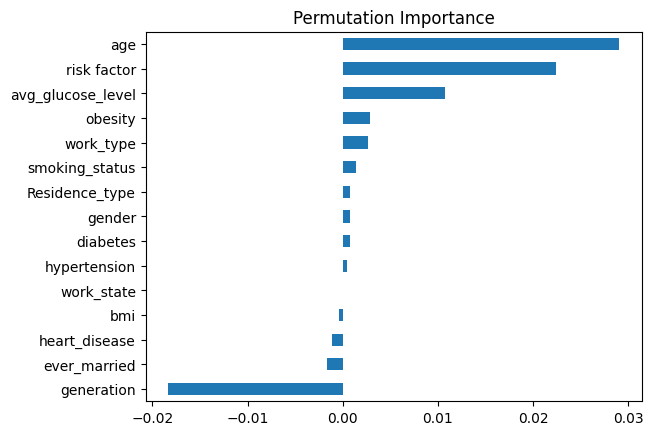

In [45]:
pi = pd.Series(dtype=float)

n_iter = 10  # 랜덤으로 특성을 섞어 평가 성능을 확인하는 과정을 몇 번 반복할지 결정합니다.
np.random.seed(2) # random seed를 고정하여 반복적으로 아래 코드를 수행해도 같은 결과가 나오게 합니다.

for feature in features:
    X_val_permed = X_val_EN.copy()

    # 모델을 재학습하지 않고, 기존 모델에서 feature 값을 여러 번(n_iter) 섞고 검증하여 평균 성능을 확인합니다.
    scores_permutated = []
    for _ in range(n_iter):
        X_val_permed[feature] = np.random.permutation(X_val_permed[feature])
        scores_permutated.append(best_model.score(X_val_permed, y_val))
    avg_score_permutated = np.mean(scores_permutated)
    print(f"Perm {feature} :: 검증 정확도 {avg_score_permutated:.6f}")

    # permutation importance는 해당 특성을 랜덤으로 섞었을 때의 성능 하락폭으로 정의됩니다.
    pi[feature] = score - avg_score_permutated

pi.sort_values().plot.barh()
plt.title("Permutation Importance")